IMPORTANT! : All the data are not uploaded to Google Drive and therefore are not available on Google Collab and for this notebook. this is due to data space constraints.

# Semantic Segmentation with CNN (Assignment 2)

In this first section we import the libraries useful for the study and create a function to display images

In [ ]:
import pathlib as pth
import os
import time
os.environ['WANDB_NOTEBOOK_NAME'] = 'assignment_3.ipynb'

import random
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
import torchmetrics
from PIL import Image

#from skimage import io
from IPython.display import Image

#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import pickle

import pandas as pd

import wandb


DATASET_DIR = pth.Path('../data/weizmann_horse_db')
DF_DIR = pth.Path('../data/dataframe')
sns.set_theme()

In order to train CNNs efficiently, we will use the GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device in use:', torch.cuda.get_device_name(device))

device in use: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
def plot_images(images, titles=[], rows=1, cols=1, figsize=(10,10), permute=False, **kwargs):
    '''
        To easily show n images in a list in a unique plot
    '''
    num_images = len(images)
    total_plots = rows * cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for i in range(num_images):
        ax = axes[i]
        if permute:
            images[i] = images[i].permute(1,2,0).detach().numpy()
        ax.imshow(images[i], **kwargs)
        ax.set_title(titles[i])
        ax.axis('off')
    for j in range(num_images, total_plots):
        axes[j].axis('off')

    plt.show()

## CNN Architecture

In this section we implement the models we are going to train and whose performance we are going to evaluate and compare.

The base block of all the CNNs we will test is a standard convolutional block, described in the next cell, consisting of a simple two-dimensional convolution followed by a batch normalisation layer and a ReLU layer to introduce non-linearity.

All of the convolutional blocks we will use next are characterised by kernels with a fixed size of 3x3. Although the choice of kernel size is the subject of numerous studies and may be a parameter to be identified by model selection, in general the use of 3x3 kernels is widespread and has proven to be very effective for several reasons:
- Computational efficiency: 3x3 kernels require fewer computations to produce a feature map and fewer parameters per layer.
- Expressiveness: the use of 3x3 kernels in series makes the network as expressive as those using kernels of variable size, and indeed introduces more levels of non-linearity, which favours learning capacity.

However, it is fair to add that while 3x3 kernels remain effective and popular today, given their past successes [1][2][3], there is a growing body of research supporting the use of larger kernels in CNNs [4], suggesting that with appropriate techniques, large kernels can provide significant benefits, particularly in capturing more comprehensive spatial information and improving performance on complex tasks.

We chose to use replicate padding where appropriate, preferring it to zero padding as it does not introduce an informationless black border, but keeps shapes and colours almost unchanged by extending the borders.

In [ ]:
class ConvReLU(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, dilation=1):
        """
        Initializes the ConvReLU module.

        Parameters
        ----------
        in_channel : int
            Number of input channels.
        out_channel : int
            Number of output channels.
        kernel_size : int or tuple, optional
            Size of the convolutional kernel. Defaults to 3.
        padding : int or tuple, optional
            Amount of 'replicate' padding added to both sides of the input. Defaults to 1.
        dilation : int or tuple, optional
            Spacing between kernel elements. Defaults to 1.
        """
        super().__init__()

        # Convolutional layer
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, padding_mode='replicate', dilation=dilation)

        # Batch normalization layer to normalize the output of the convolutional layer
        self.bn = nn.BatchNorm2d(out_channel)

        # ReLU activation function to introduce non-linearity
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        Defines the forward pass of the ConvReLU module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after applying convolution, batch normalization, and ReLU activation.
        """
        # Apply convolutional layer
        x1 = self.conv(x)

        # Apply batch normalization
        x2 = self.bn(x1)

        # Apply ReLU activation function
        x3 = self.relu(x2)

        # Return the output tensor
        return x3


The convolutional networks that will be the subject of this study will be characterized by an encoder-decoder structure in which there is no dense linear bottleneck, but the totality of the networks is convolutional.

Below we see 3 complex modules representing an encoder module, a decoder module and a module based on dilated convolutions:
- The encoder block is a series of n convolutional blocks implemented above, where the first one extends the input channels to the output channels and the subsequent ones maintain the same number. A padding pixel is used to maintain the image resolution after appling convolutions with 3x3 kernels. Finally, max-pooling is used to reduce the dimensionality of the feature map, increasing the invariance and preserving the indices for later use in the convolutional decoder.
- The decoder block is the inverse of the encoder block, but does not use deconvolution. It starts with a max unpooling layer, where the indices passed by the encoder are used to increase the precision of the transformation, and then there are a series of convolutional blocks, the last of which expands the number of channels.
- The third block, called DilatedConvolutionBlock, is a block of k convolutional levels that uses dilated convolutions to systematically aggregate multi-scale contextual information without losing resolution. Each successive convolutional block exponentially increases the dilation to exponentially increase the module's reception range.

The last two blocks can be used as final blocks, so the last activation function can be omitted.

For each max pooling or unpooling layer is used a 2x2 kernel with a stride of 2

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, depth=2, kernel_size=3, padding=1):
        """
        Initializes the EncoderBlock module.

        Parameters
        ----------
        in_channel : int
            Number of input channels.
        out_channel : int
            Number of output channels.
        depth : int, optional
            Number of ConvReLU layers in the block. Defaults to 2.
        kernel_size : int or tuple, optional
            Size of the convolutional kernel. Defaults to 3.
        padding : int or tuple, optional
            Amount of 'replicate' padding added to both sides of the input. Defaults to 1.
        """
        super().__init__()

        # convolutional layer
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                # the first increase the channels
                self.layers.append(ConvReLU(in_channel, out_channel))
            else:
                # the others keep the same number of channels
                self.layers.append(ConvReLU(out_channel, out_channel, kernel_size, padding))

        # max pooling layer that returns idices
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        """
        Defines the forward pass of the EncoderBlock module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after applying depth convolutions and max pooling.
        torch.Tensor
            Indices of the max elements retained for each input window.
        """
        # each layer is applied to the input
        for layer in self.layers:
            x = layer(x)
        # the max pooling layer is applied
        x, ind = self.pool(x)
        # the module returns the output feature map and the indices selected by the max pooling
        return x, ind

class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, depth=2, kernel_size=3, padding=1, classification=False):
        """
        Initializes the DecoderBlock module.

        Parameters
        ----------
        in_channel : int
            Number of input channels.
        out_channel : int
            Number of output channels.
        depth : int, optional
            Number of ConvReLU layers in the block. Defaults to 2.
        kernel_size : int or tuple, optional
            Size of the convolutional kernel. Defaults to 3.
        padding : int or tuple, optional
            Amount of 'replicate' padding added to both sides of the input. Defaults to 1.
        classification : bool, optional
            Whether the block is used for classification. Defaults to False.
        """
        super().__init__()

        # unpooling layer that uses the indices given in input to increase the fidelity of the reconstruction
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # concolutional layers
        self.layers = nn.ModuleList()
        for i in range(depth):
            # the last one reduce the channels
            if classification and i == depth - 1:
                # if the module is the last one of the network the ReLU is omitted for classification
                self.layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_channel, out_channel, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_channel, in_channel, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind, unpool_out_size):
        """
        Defines the forward pass of the DecoderBlock module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.
        ind : torch.Tensor
            Indices of the max elements retained for each input window.
        unpool_out_size : tuple
            Size of the output tensor after unpooling.

        Returns
        -------
        torch.Tensor
            Output tensor after applying unpooling and depth convolutions.
        """
        # first is applied the unpooling
        x = self.unpool(x, ind, output_size=unpool_out_size)
        # then each convolutional layer
        for layer in self.layers:
            x = layer(x)
        return x

class DilatedConvolutionBlock(nn.Module):
    def __init__(self, channel, depth=5, classification=False):
        """
        Initializes the DilatedConvolutionBlock module.

        Parameters
        ----------
        channel : int
            Number of input and output channels.
        depth : int, optional
            Number of ConvReLU layers in the block. Defaults to 5.
        classification : bool, optional
            Whether the block is used for classification. Defaults to False.
        """
        super().__init__()

        # the convolutional layers
        self.layers = nn.ModuleList()
        # the first two layer needs 1 dilatation
        self.layers.append(ConvReLU(channel, channel, padding=1, dilation=1))
        for i in range(depth - 1):
            # if the module is the last of the network the ReLU is omitted
            if classification and i == depth - 2:
                self.conv = nn.Conv2d(channel, channel, kernel_size=3, padding=2**i, padding_mode='replicate', dilation=2**i)
            else:
                self.layers.append(ConvReLU(channel, channel, padding=2**i, dilation=2**i))

    def forward(self, x):
        """
        Defines the forward pass of the DilatedConvolutionBlock module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after applying depth dilated convolution.
        """
        # each layer is applied to the input
        for layer in self.layers:
            x = layer(x)
        return x


The first CNN architecture is inspired by SegNet; it is divided into an ecnoder consisting of 3 encoder modules, a bottleneck consisting of a simple encoder and decoder module, and the actual decoder consisting of 3 decoder modules. For each max pooling in an encoder block, there is a counterpart in a decoder block that reverses the transformation using the indices generated by the first sampling.

In [ ]:
class MiniSegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32) -> None:
        """
        Initializes a MiniSegNet CNN.

        Parameters
        ----------
        in_channels : int, optional
            Number of input channels. Defaults to 3.
        out_channels : int, optional
            Number of output channels. Defaults to 1.
        features : int, optional
            Number of features to use in the network. Defaults to 32.
        """
        super().__init__()

        # Encoder blocks
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 4, features * 4, depth=3)
        self.bottleneck_dec = DecoderBlock(features * 4, features * 4, depth=3)

        # Decoder blocks
        self.dec0 = DecoderBlock(features * 4, features * 2)
        self.dec1 = DecoderBlock(features * 2, features)
        self.dec2 = DecoderBlock(features, out_channels, classification=True)

    def forward(self, x):
        """
        Defines the forward pass of the MiniSegNet.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after passing through the network.
        """
        # Encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)

        # Bottleneck
        b0, indb = self.bottleneck_enc(e2)
        b1 = self.bottleneck_dec(b0, indb, e2.size())

        # Decoder
        d0 = self.dec0(b1, ind2, e1.size())
        d1 = self.dec1(d0, ind1, e0.size())

        # Classification layer
        output = self.dec2(d1, ind0, x.size())
        return output


The second CNN is a modification of the first that replaces the simple bottleneck of the MiniSegNet with a dilated, 5-level deep convolution module whose purpose is to introduce global and not just local operations that aggregate information from a reception field that extends to 32x32 pixels. This modification, as much as it seems to increase the complexity of the model, actually goes to decrease the total number of network parameters.

In [ ]:
class MiniSegNetD(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32) -> None:
        """
        Initializes a MiniSegNetD CNN.

        Parameters
        ----------
        in_channels : int, optional
            Number of input channels. Defaults to 3.
        out_channels : int, optional
            Number of output channels. Defaults to 1.
        features : int, optional
            Number of features to use in the network. Defaults to 32.
        """
        super().__init__()

        # Encoder blocks
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4)

        # Dilated bottleneck
        self.dilated_bottleneck = DilatedConvolutionBlock(features * 4)

        # Decoder blocks
        self.dec0 = DecoderBlock(features * 4, features * 2)
        self.dec1 = DecoderBlock(features * 2, features)
        self.dec2 = DecoderBlock(features, out_channels, classification=True) # No activation

    def forward(self, x):
        """
        Defines the forward pass of the MiniSegNetD.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after passing through the network.
        """
        # Encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)

        # Dilated bottleneck
        b = self.dilated_bottleneck(e2)

        # Decoder
        d0 = self.dec0(b, ind2, e1.size())
        d1 = self.dec1(d0, ind1, e0.size())

        # Classification layer
        output = self.dec2(d1, ind0, x.size())
        return output


Finally, the last CNN implemented is a further modification of the previous MiniSegNetD that introduces a residual connection, the bottleneck output is summed with its input before passing through the decoder. This addition would improove the learning of the encoder and provide the decoder with more low-level information than those generated by the dilated module.

In [ ]:
class MiniSegNetDS(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32) -> None:
        """
        Initializes a MiniSegNetDS CNN.

        Parameters
        ----------
        in_channels : int, optional
            Number of input channels. Defaults to 3.
        out_channels : int, optional
            Number of output channels. Defaults to 1.
        features : int, optional
            Number of features to use in the network. Defaults to 32.
        """
        super().__init__()

        # Encoder blocks
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4)

        # Bottleneck
        self.dilated_bottleneck = DilatedConvolutionBlock(features * 4)

        # Decoder blocks
        self.dec0 = DecoderBlock(features * 4, features * 2)
        self.dec1 = DecoderBlock(features * 2, features)
        self.dec2 = DecoderBlock(features, out_channels, classification=True) # No activation

    def forward(self, x):
        """
        Defines the forward pass of the MiniSegNetDS.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after passing through the network.
        """
        # Encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)

        # Bottleneck
        b = self.dilated_bottleneck(e2)

        # Residual connection
        sum = b + e2

        # Decoder
        d0 = self.dec0(sum, ind2, e1.size())
        d1 = self.dec1(d0, ind1, e0.size())

        # Classification layer
        output = self.dec2(d1, ind0, x.size())
        return output


## Training

This section was used to perform training of the models.

First, the task and the dataset were studied and was understood how to organize the data structure to provide input to the CNNs during training. After an initial idea of not performing image scaling, it was instead decided to apply it and set the resolution to 512x512.

In [ ]:
if not os.path.isdir(DATASET_DIR): print('Cartella non trovata')
horses = [torchvision.io.read_image(str(img)) for img in (DATASET_DIR / 'horse').iterdir() if img.suffix == '.png']
print('Dataset len:', len(horses))

Dataset len: 327


This size was decided because powers of two allow the network perfect scaling of the feature maps, whose size halves (becomes one quarter counting the total pixels but each side halves) with each max pooling step. It also turned out to be close to the average size of the images in the dataset. Below we report the calculation of the mean and variance for each dimension (height and width) and the distribution of total pixels per image.

Looking at the variance we note that it is high, but the benefits of resizing the images to a fixed size are a huge decrease in training time, as varying image sizes do not allow to operate on batches of data, which would be uneven, plus there are no real downsides to resizing, as it is only beneficial because it introduces noise into the dataset due to images always being the same size but of lower or higher original resolution, making the model more robust to overfitting.

In [ ]:
print('mean dimension:', np.mean([x.shape[1] for x in horses]), np.mean([x.shape[2] for x in horses]))
print('variance dimension:', np.std([x.shape[1] for x in horses]), np.std([x.shape[2] for x in horses]))

mean dimension: 418.434250764526 530.9204892966361
variance dimension: 153.046817169928 198.91308578471322


Below we visualize the distribution mentioned earlier

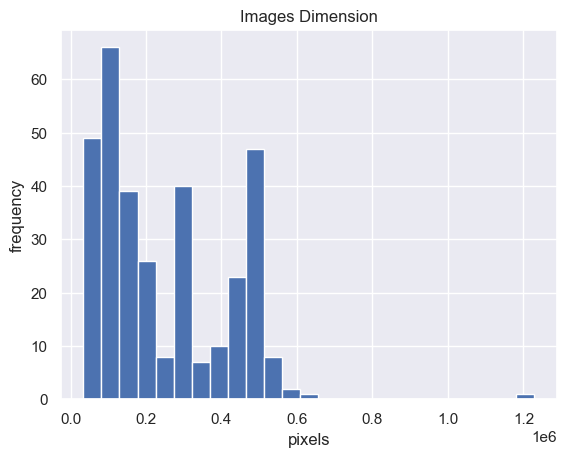

In [ ]:
def plot_histogram(data, bins=None, title="Histogram", xlabel="Value", ylabel="Frequency"):

    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

dimensions = [ x.shape[1]*x.shape[2] for x in horses]
plot_histogram(dimensions, bins=25, title="Images Dimension", xlabel="pixels", ylabel="frequency")


Below is the implementation of a custom Dataset that allows the use of transformations applicable to each input before forming the data batch. We used this feature to introduce data agumentation, specifically we use random transformations applied to the inputs at training time to introduce noise into the data, and make the task more complex but effective.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dir_1, dir_2, indexes, size=(512,512), transform=None, color_tr=None, gpu=True):
        """
        Initializes the ImageDataset.

        Parameters
        ----------
        dir_1 : Path
            Directory containing the images.
        dir_2 : Path
            Directory containing the masks.
        indexes : list of int
            List of indexes to filter the images and masks.
        size : tuple of int, optional
            Size to which the images and masks should be resized. Defaults to (512, 512).
        transform : callable, optional
            A function/transform to apply to both the image and mask. Defaults to None.
        color_tr : callable, optional
            A function/transform to apply to the image only. Defaults to None.
        gpu : bool, optional
            Flag to indicate whether to move tensors to GPU. Defaults to True.
        """

        # Resize transform
        tr = transforms.Compose([transforms.Resize(size)])

        # Load and resize images
        self.images = [tr(Image.open(img))
                       for img in dir_1.iterdir() if img.suffix == '.png' and int(img.stem[-3:]) in indexes]

        # Load and resize masks
        self.masks = [tr(Image.open(img))
                      for img in dir_2.iterdir() if img.suffix == '.png' and int(img.stem[-3:]) in indexes]

        # Store additional transforms
        self.transform = transform
        self.color_tr = color_tr

        # Define transforms to convert images and masks to tensors
        self.to_t_i = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32)
        ])
        self.to_t_m = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32)
        ])

        # Flag for GPU usage
        self.gpu = gpu

    def __len__(self):
        """
        Returns the total number of samples.
        """
        return len(self.images)

    def __getitem__(self, index):
        """
        Retrieves the image and mask at the specified index.

        Parameters
        ----------
        index : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple of torch.Tensor
            Tuple containing the image and the mask as tensors.
        """
        # Retrieve image and mask
        image = self.images[index]
        mask = self.masks[index]

        # Apply color transform if specified
        if self.color_tr:
            image = self.color_tr(image)

        # Apply additional transform if specified
        if self.transform:
            image, mask = self.transform([image, mask])

        # Convert images and masks to tensors and move to GPU if specified
        if self.gpu:
            return self.to_t_i(image).to('cuda'), self.to_t_m(mask).to('cuda')
        else:
            return self.to_t_i(image), self.to_t_m(mask)


Below is a function called inside the training loop that performs the classic gradient descent aglorithm over an entire epoch. A gradient accumulation mechanism is present to allow splitting the size of the batch that can be loaded into memory and through which to compute the predictions and gradient versus the number of samples on which to compute the gradient and do the learning step. Useful when training models on different machines with different GPUs.

In [ ]:
def train_one_epoch(epoch, accumulate_grad, tot_batch, tr_data_loader, model, optimizer, criterion):
    tr_loss = 0.0
    epoch_time_start = time.time()

    # reset of gradients
    optimizer.zero_grad()

    with tqdm.tqdm(total=tot_batch, desc=f'epoch {epoch}') as pbar:

        batch_loss = 0
        for i, batch in enumerate(tr_data_loader):

            input, labels = batch

            # Forward Phase
            output = model(input)

            loss = criterion(output, labels)
            tr_loss += loss.item()

            loss = loss/accumulate_grad
            batch_loss += loss.item()

            # Backward Phase - Gradient Accumulation
            loss.backward()
            if i%accumulate_grad == 0:
                optimizer.step()

                # reset of gradients
                optimizer.zero_grad()

                wandb.log({'tr_batch_loss': batch_loss})
                batch_loss = 0

            pbar.update(1)

    return tr_loss/(i + 1), time.time() - epoch_time_start

Function that calculates a truncated mean: calculates the mean over k values excluding the greatest and the smallest. The sense of the function is to create an average that is less sensitive to outliers and use it for the mechanism of early stopping.

In [ ]:
def trimmed_mean(points, outlier_num = 1):
    points.sort()
    return np.mean(points[outlier_num:-outlier_num])

Simple functions to save the status of the model, optimizer, and vairables useful for stopping and then resuming the learning phase.

In [ ]:
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

def load_checkpoint(load_path, model=None, optimizer=None):
    checkpoint = torch.load(load_path)

    if model:
        model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

    return model, optimizer, epoch

The original dataset is divided before the beginning of the model selection phase into training set, validation set and test set. While the first two will be used to select the best candidate among the studied models the third will be used later for the Model Evaluation phase.

The main training loop was built to interact via the wandb api and save all the metrics computed at each iteration, and was used to perform several preliminary Bayesian searches to fix a good combination of hyperparameters that did not particularly favor any of the tested networks and then compare them equally. Specifically, 3 Bayesian searches were performed, one for each network type, and all suggested the same combination of hyperparameters for training:
- Optimiser: AdamW is an optimisation algorithm that combines exponential learning rate decay, momentum and weight decay. Compared to Adam, AdamW applies the weight decay separately from the gradient update, improving the generalisation of the model and reducing overfitting. The values of the learning rate and weight decay are set to 0.0005 and 0.005, respectively.
- Data agumentation: use of a random horizontal flip, cropping of the image to reduce it to a maximum of 0.5 from the original size, modification of the exposure and slight colour distortion. In contrast, the random vertical flip of the image only made the learning process worse.
- Maximum epoch at 200 and minimum at 100, with early stopping. None of the runs showed signs of overfitting, probably due to the reduced network complexity and data agumentation; the early stop, however, showed an early termination of the less promising runs.

The loss function used is the Binary Cross Entropy, calculated on the probability of the one class to be predicted; in addition, a second supporting metric, the Jaccard Similarity, was used, calculated on the set of pixels described by the mask predicted by the model compared with the groud trooth. The second metric is useful because it better represents a human assessment of the effectiveness of semantic segmentation.

In [ ]:
def train(config=None):

    # manual setted variable needed by the training process
    verbose = True
    agument_validation = False
    avg_on_epoch = 6
    val_loss_list = 18

    test_len = 51
    val_len = 48
    tr_len = 228

    # the connection with one db if 'agent' is not used
    with wandb.init(entity='giacomoaru', project='ISPR', config=config):

        if config is None:
            config = wandb.config
            seed = int(time.time())
            save_path = '../data/CNN/' + config.classifier_type + '_tmp'
        else:
            seed = config.seed
            save_path = '../data/CNN/' + config.classifier_type + '_' + config.name

        # create all the folder to save the objs
        if config.save_state:
            if not os.path.exists(save_path + '/sample_mask'): os.makedirs(save_path + '/sample_mask')
            if not os.path.exists(save_path + '/sample_segmentation'): os.makedirs(save_path + '/sample_segmentation')

            with open(save_path + '/config.pk', 'wb+') as file:
                pickle.dump(config, file, pickle.HIGHEST_PROTOCOL)

        # batch size * accumulate gradient needs to remain constant over all the machine used in the model selection
        batch_size = 6
        accumulate_gradient = 2
        wandb.log({"seed": seed, 'batch_size': batch_size, 'accumulate_gradient':accumulate_gradient})

        # dataset are divided always in the same way an then shuffled
        tot_indexes = [i + 1 for i in range(1, 327)]
        random.seed(1240)
        random.shuffle(tot_indexes)
        train_data_indexes = tot_indexes[:tr_len]
        val_data_indexes  = tot_indexes[tr_len:val_len + tr_len - 1] + [1]

        val_loss_values = [np.Inf]*(val_loss_list-1)
        early_stop = False

        # the seed is saved to replicate the training in all aspects
        torch.manual_seed(seed)

        # the transformation are selected
        tr = [transforms.RandomHorizontalFlip(0.5)]
        if config.vertical_flip == 1:
            tr.append(transforms.RandomVerticalFlip(0.5))
        tr.append(transforms.RandomResizedCrop((512,512), scale=(config.crop, 1.0)))
        custom_transform = transforms.Compose(tr)

        # the color transformation is applied only to the immage not the mask
        color_tr = transforms.ColorJitter(brightness=config.jitter_b, hue=.4)

        train_dataset = ImageDataset(DATASET_DIR / 'horse', DATASET_DIR / 'mask', train_data_indexes,
                                     (512,512), custom_transform, color_tr)
        if agument_validation:
            validation_dataset = ImageDataset(DATASET_DIR / 'horse', DATASET_DIR / 'mask', val_data_indexes,
                                              (512,512), custom_transform, color_tr)
        else:
            validation_dataset = ImageDataset(DATASET_DIR / 'horse', DATASET_DIR / 'mask', val_data_indexes,
                                              (512,512))

        # this is a sample from the validation set used to show the learning
        # process of the cnn
        test_image = [transforms.Resize((512,512))(torchvision.io.read_image(str(DATASET_DIR / 'horse/horse001.png')))] + list(next(iter(validation_dataset)))

        tr_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        tot_batch = len(tr_loader)
        min_val_loss = np.Inf
        max_val_jac = -np.Inf
        mean_epoch_time = 0

        # the model, optimizer, loss is created before starting the training
        if config.classifier_type == 'MiniSegNetD':
            model = MiniSegNetD().to(device)
        elif config.classifier_type == 'MiniSegNet':
            model = MiniSegNet().to(device)
        elif config.classifier_type == 'MiniSegNetDS':
            model = MiniSegNetDS().to(device)
        else:
            print('WRONG MODEL TYPE')
            raise Exception('WRONG MODEL TYPE')

        criterion = nn.BCEWithLogitsLoss()
        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum, weight_decay=config.weight_decay)
        else:
            print('WRONG OPTIMIZER TYPE')
            raise Exception('WRONG OPTIMIZER TYPE')
        jaccard = torchmetrics.classification.BinaryJaccardIndex(threshold=0.5).to(device)

        # training start
        if verbose: print('starting training')
        for epoch in range(config.epochs):

            # model modules switch their behaviour to "training mode"
            model.train()
            # to perform SGD over one epoch
            tr_loss, epoch_time = train_one_epoch(epoch, accumulate_gradient, tot_batch, tr_loader, model, optimizer, criterion)
            mean_epoch_time += epoch_time

            # model modules switch their behaviour to "evaluation mode"
            model.eval()

            # context-manager that disables gradient calculation
            with torch.no_grad():

                # validation error is calculated in parts using a batch mechanism to control memory usage
                val_loss = 0
                val_jac = 0
                for j, (input, labels) in enumerate(val_loader):

                    output = model(input)

                    val_loss += criterion(output, labels).item()
                    val_jac += jaccard(output>0, labels)

                val_loss = val_loss/(j + 1)
                val_jac = val_jac/(j + 1)

                # the max or min of every metrics are saved
                if max_val_jac < val_jac:
                    max_val_jac = max(max_val_jac, val_jac)
                    if config.save_state:
                        save_checkpoint(model, optimizer, save_path + '/max_jac', epoch)
                if min_val_loss > val_loss:
                    min_val_loss = min(min_val_loss, val_loss)
                    if config.save_state:
                        save_checkpoint(model, optimizer, save_path + '/min_loss', epoch)

                # the segmentation over the sample selected before is computed and saved
                out_test = model(torch.stack([test_image[1]]))
                out_mask_rappresentation = torchvision.utils.draw_segmentation_masks(test_image[0], (out_test[0]>0), colors='red')
                image_array = [test_image[0],
                               torchvision.utils.draw_segmentation_masks(test_image[0], test_image[2].bool(), colors='red'),
                               out_mask_rappresentation]
                image_array = torchvision.utils.make_grid(image_array)
                images = wandb.Image(image_array, caption="Original - Target - Output")

                # the visualization of the segmentation is saved
                if config.save_state:
                    img = Image.fromarray((out_test.cpu().numpy()[0][0] > 0.5).astype(int))
                    img.save(save_path + '/sample_mask/' + str(epoch) + '.png')
                    img = Image.fromarray(out_mask_rappresentation.permute(1, 2, 0).cpu().numpy(), mode='RGB')
                    img.save(save_path + '/sample_segmentation/' + str(epoch) + '.png')

                jac_similarity_sample = jaccard(out_test[0], test_image[2])

                # all the metrics computed are saved in wandb server
                wandb.log({'tr_loss': tr_loss, 'val_loss':val_loss, 'epoch':epoch, 'val_jac':val_jac,
                           "validation sample": images, 'jac_sample':jac_similarity_sample})
                if verbose: print(f'ep time: {epoch_time:.1f} tr: {tr_loss:.6f} vl: {val_loss:.6f} jac: {val_jac:.6f}')

                # finally the early stopping mechanism is checked and trigged if needed
                val_loss_values.append(val_loss)
                mean_1 = trimmed_mean(val_loss_values[:avg_on_epoch])
                mean_2 = trimmed_mean(val_loss_values[-avg_on_epoch:])
                if mean_1 < mean_2 and epoch > config.min_epochs:
                    # early stop
                    print('EARLY STOPPING TRIGGERED:', mean_1, mean_2)
                    early_stop = True
                    break
                else:
                    val_loss_values.pop(0)
        mean_epoch_time /= epoch + 1

        if early_stop:
           wandb.log({'stopped':True})
        else:
            wandb.log({'stopped':False})

        wandb.log({'mean_epoch_time':mean_epoch_time, 'min_val_loss':min_val_loss, 'max_val_jac':max_val_jac})

In [ ]:
#wandb.agent('giacomoaru/ISPR/8o3ir5h4', train, count=10)
#train(config)
#wandb.finish()

## Model Selection

In this section, several models were compared in order to select the best

Below we see the total number of trainable parameters for each of the 3 types of studied networks.

In [ ]:
models = [MiniSegNet(), MiniSegNetD(), MiniSegNetDS()]
for model in models:
    tot_param =  sum(p.numel() for p in model.parameters())
    train_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model.__class__.__name__, '-> total trainable paraeters =', train_param )

MiniSegNet -> total trainable paraeters = 1461889
MiniSegNetD -> total trainable paraeters = 1314049
MiniSegNetDS -> total trainable paraeters = 1314049


The final comparison was made by fixing a combination of good hyperparameters and training each network 3 times with different random initializations of the weights. In the following graphs we have a line for each type of model, surrounded by a shade indicating the maxima and minima of the 3 different initializations, we see that the results are not particularly dependent on the initialization.

The first graph shows the training loss

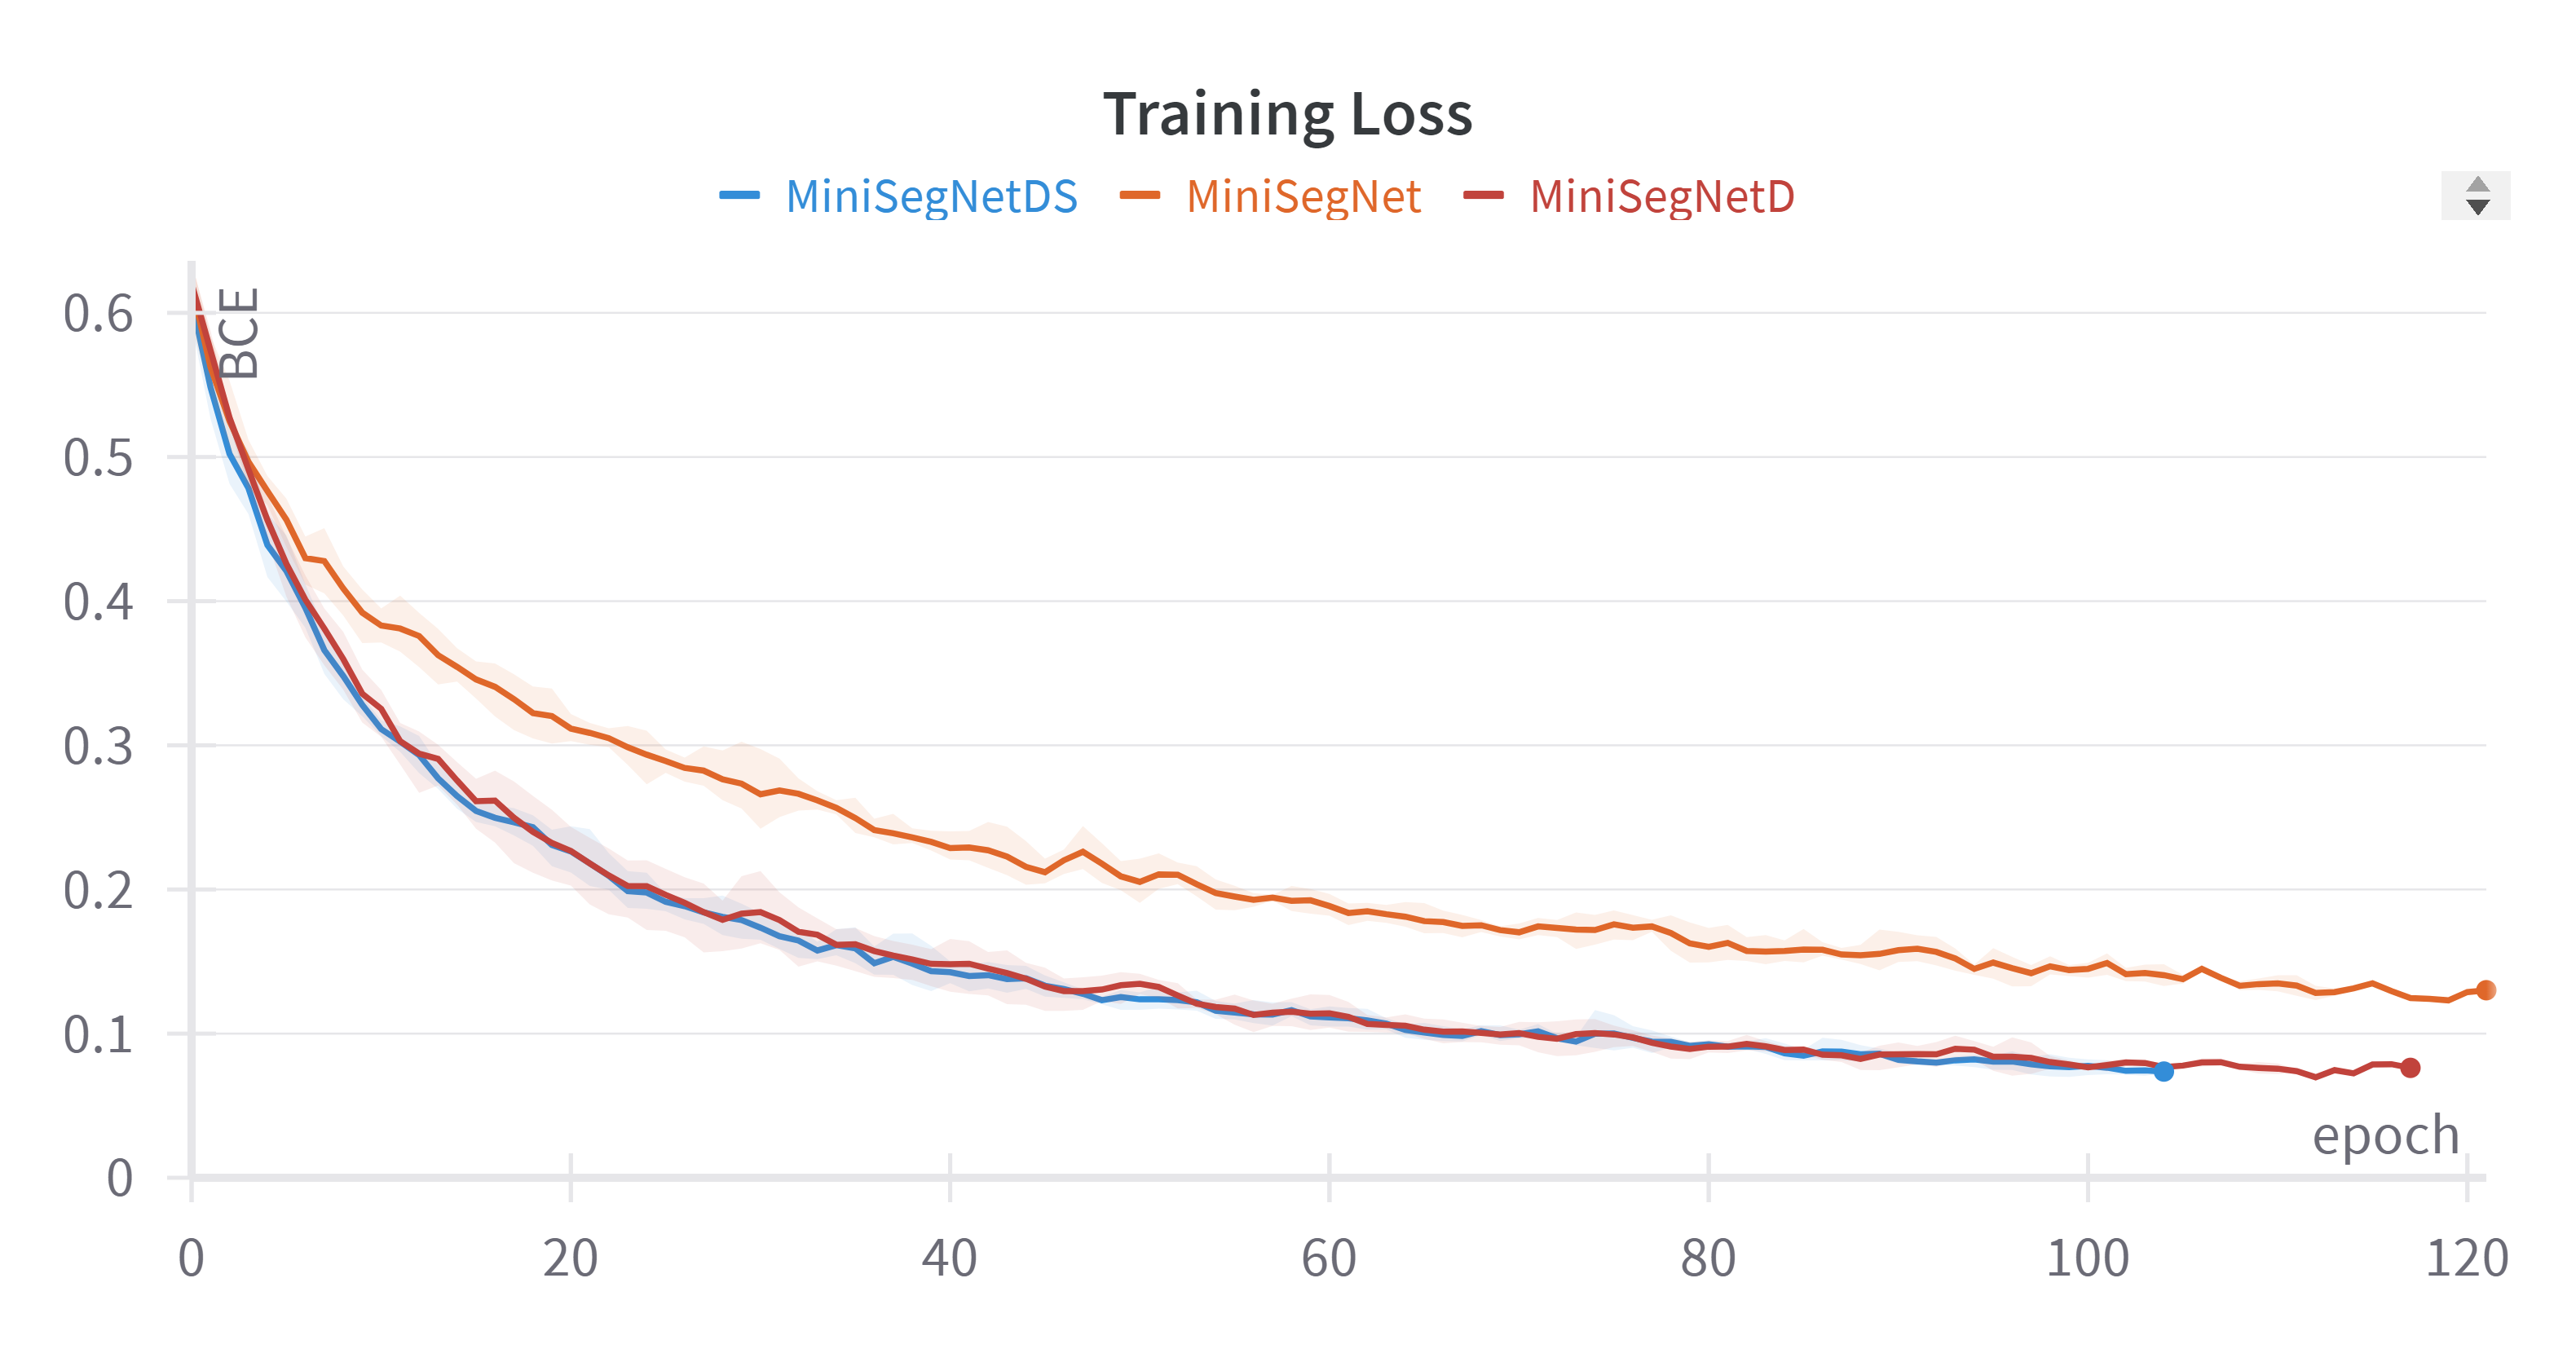

In [ ]:
Image("../data/plot/Training Loss.png")

The next graph shows the validation loss, we notice that no model show signs of overfitting and that it appears to follow the trend of the training loss but the curve is more noisy.

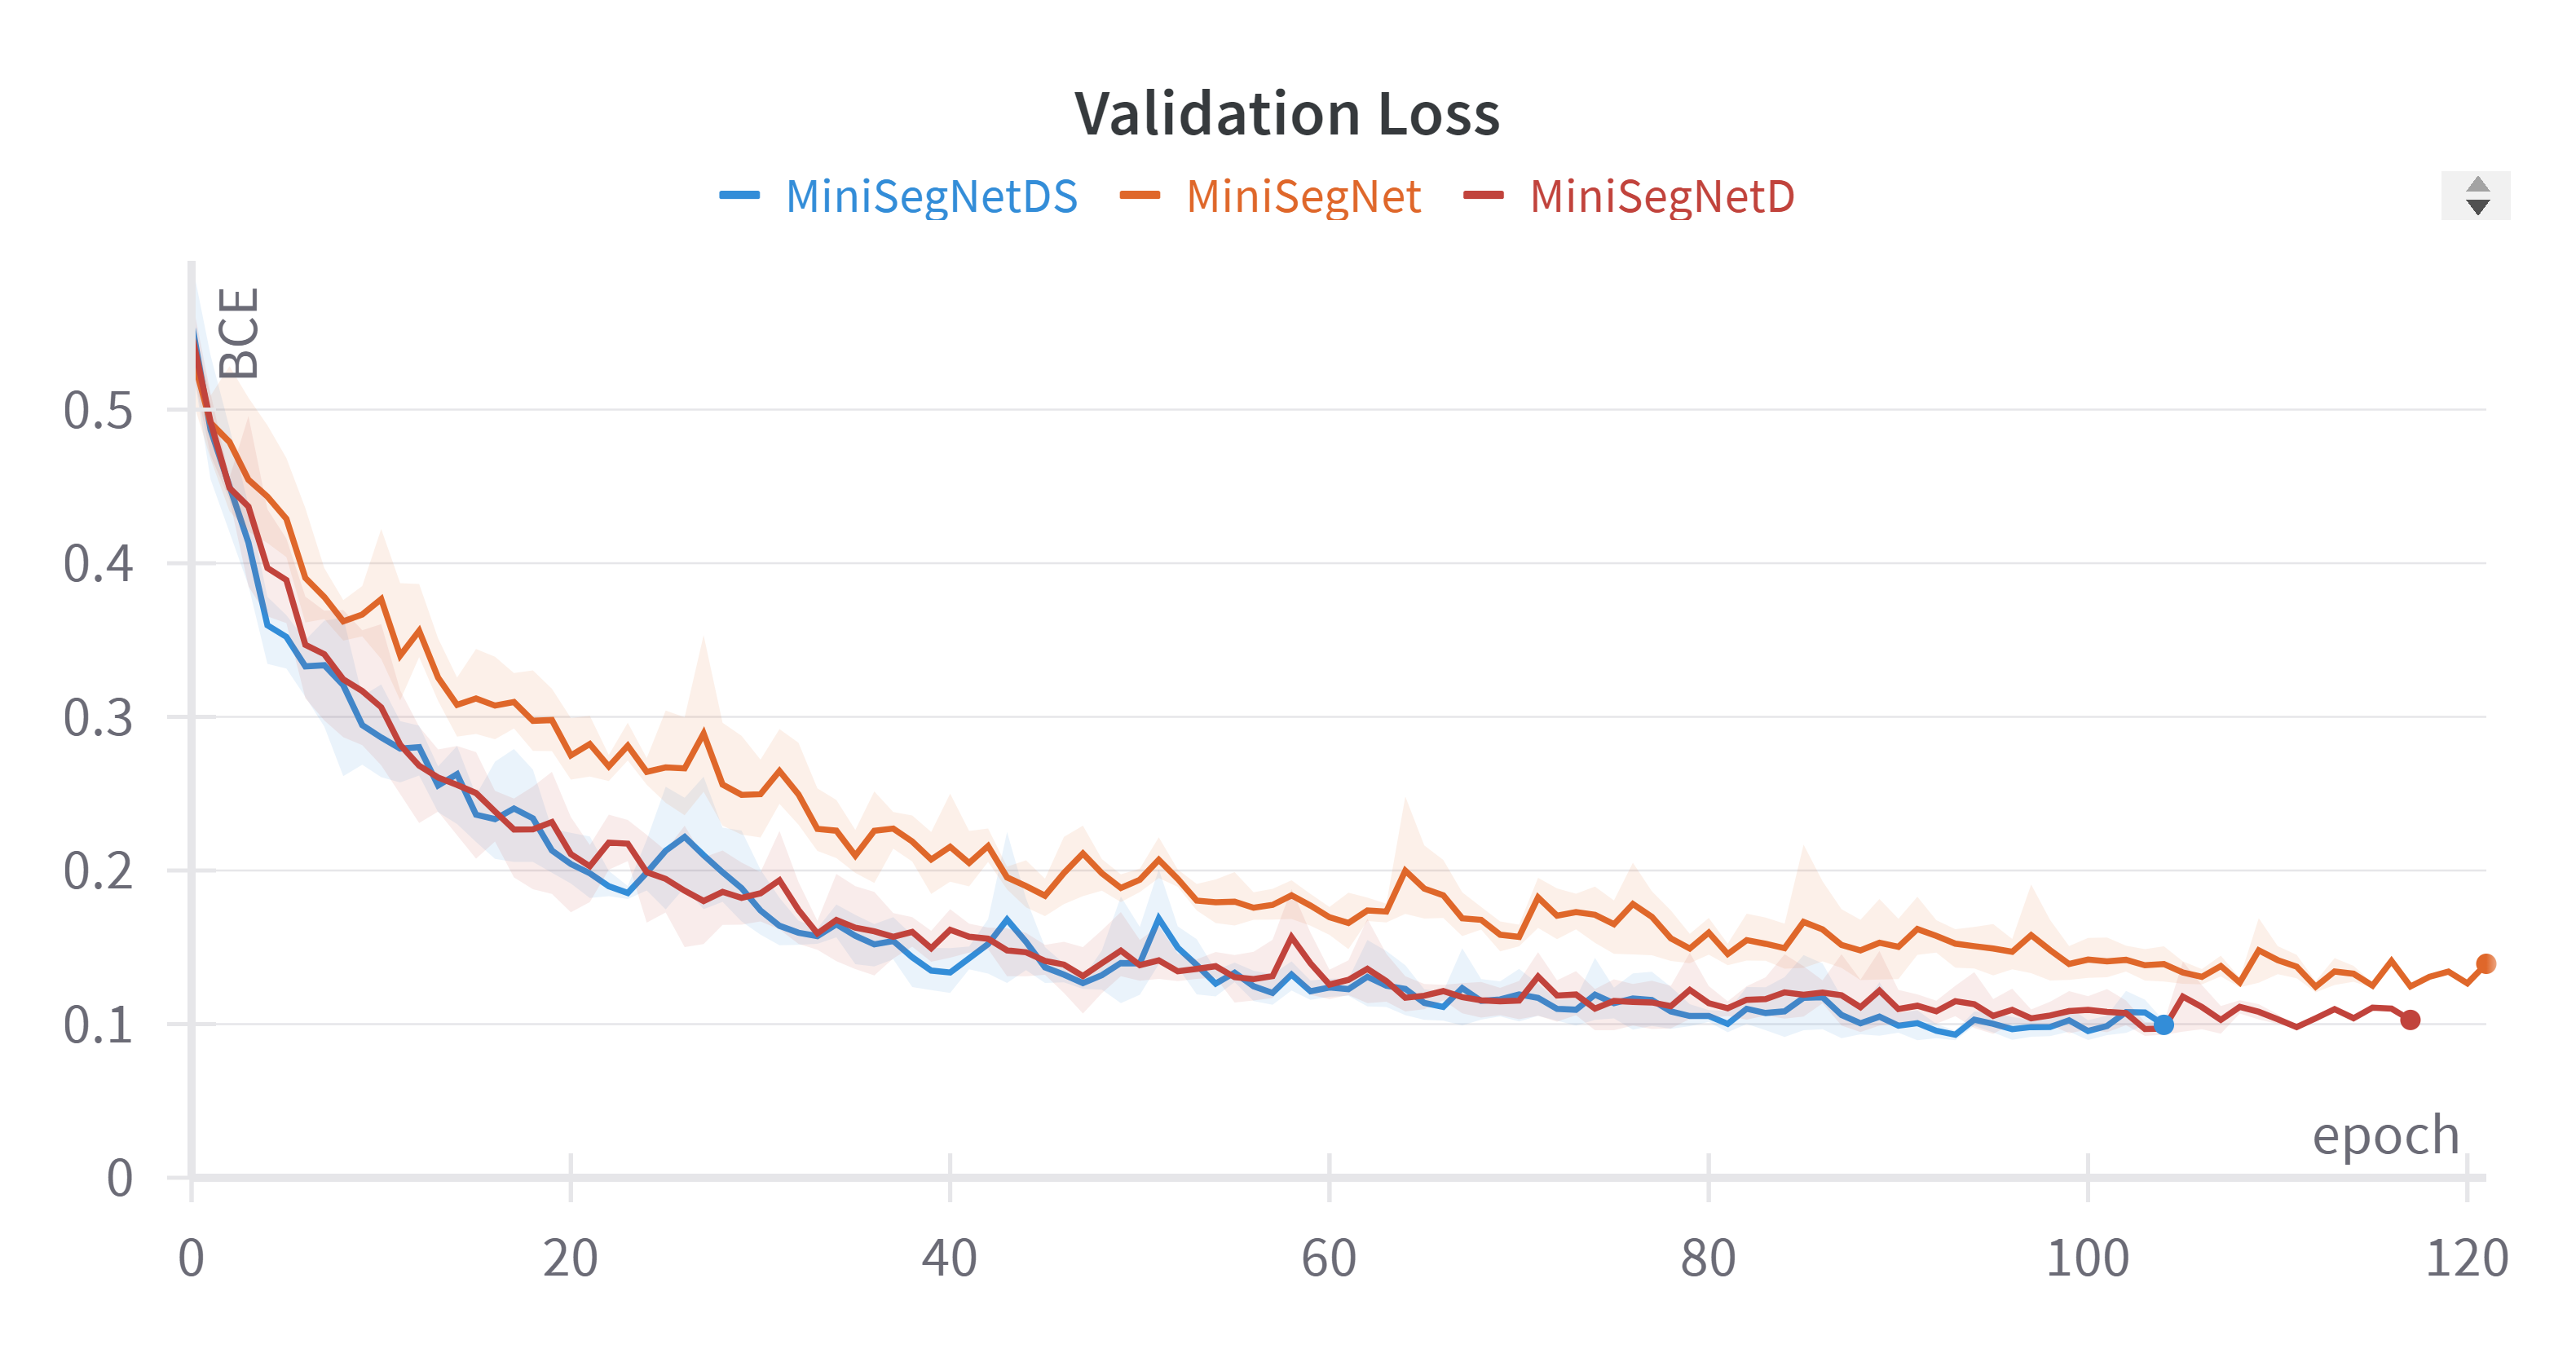

In [ ]:
Image("../data/plot/Validation Loss.png")

Finally we show the average jaccard similarity, caolcolated on the validation set.

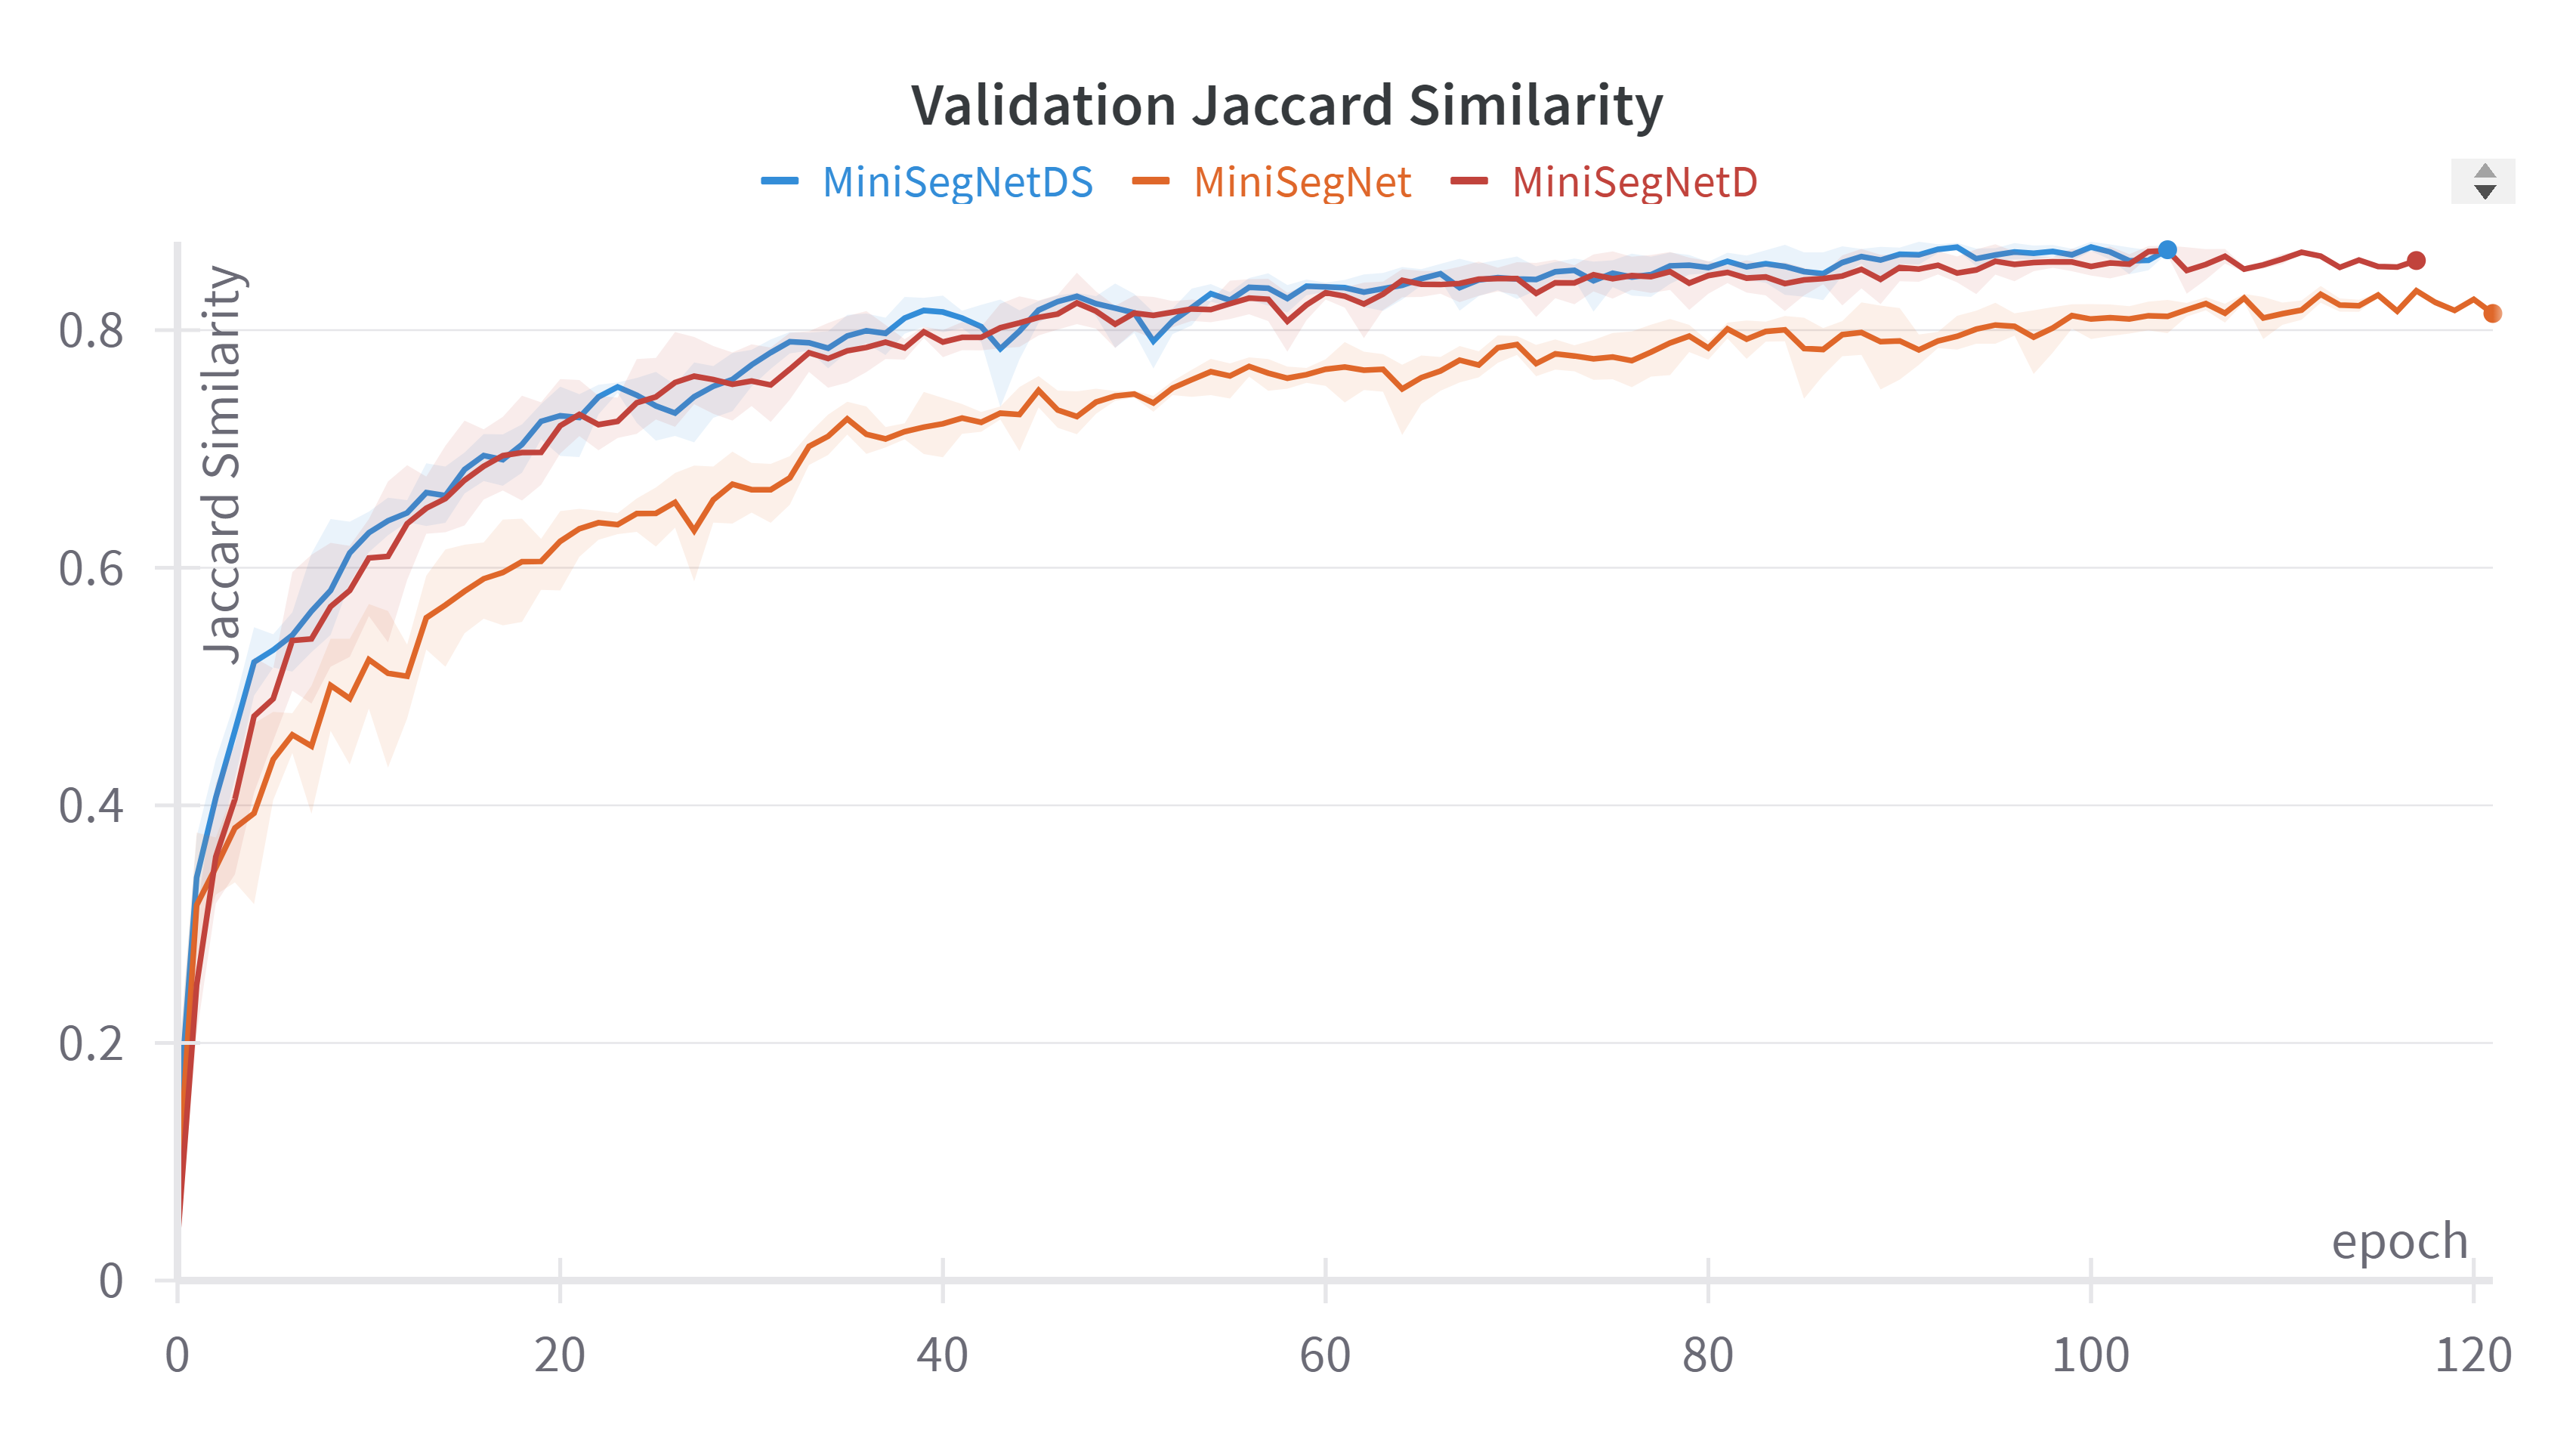

In [ ]:
Image("../data/plot/Validation Jaccard Similarity.png")

For demonstration purposes, we saved at each epoch the segmentation of a sample image, belonging to the validation set, computed by the model. This image proved to be particularly complicated to segment, always falling among the images with a lower jaccard similarity value. Below we show those computed on the last training of the model that performed best in previous tests: MiniSegNetDS, which slightly outperformed MiniSegNetD.
it is interesting to note how the segmentation, starts first very imprecise, then follows a more correct but still coarse segmentation and in correspondence with the end of the learning, the network learns to recognize also the details of the images and correctly divide the more particular parts of the horse such as legs and tail.

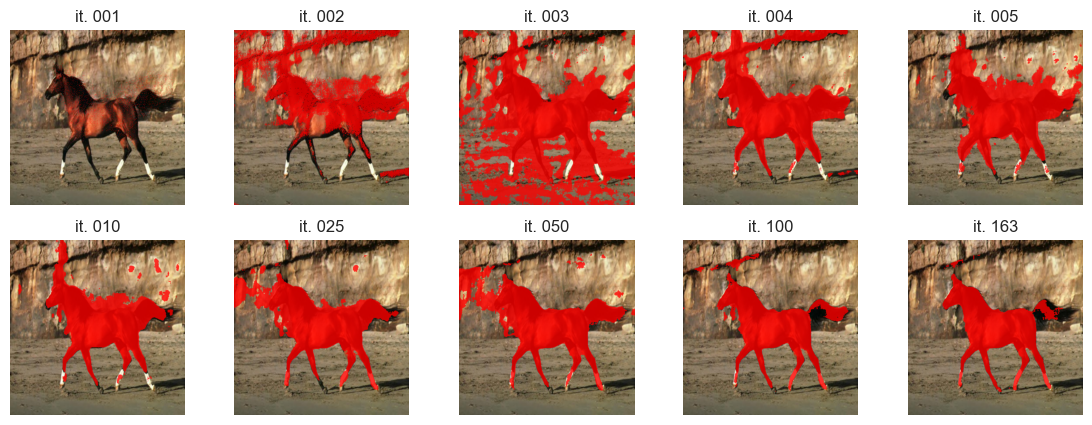

In [ ]:
horses = [torchvision.io.read_image(str(img)) for img in (pth.Path('../data/plot/sample segmentation')).iterdir() if img.suffix == '.png']
names = ['it. ' + img.stem for img in (pth.Path('../data/plot/sample segmentation')).iterdir() if img.suffix == '.png']
plot_images(horses, names, 2,5, permute=True, figsize=(14,5))

We can end the comparison phase of the different models with a few remarks: the best model was the one that implemented both the dilated convolution module and the residual connection. Although the latter addition did not give great improvements the former instead shows an ability to increase the correctness of segmentation while also bringing a reduction in total parameters, a sign of how well dilated convolutions can perform in dense problems such as semantic segmentation.

## Model Evaluation

In this section we will perform the Model Evaluation on the model that achieved the best results in the previous phase: MiniSegNetDS.

A final training was performed on the whole training set plus validation set to obtain the final model, evaluated in this section.

In [ ]:
def save_df_dict(df_dict):
    for key in df_dict:
        df_dict[key].to_csv(DF_DIR / (str(key) + '.csv'), sep=',', index=False)
def load_df_dict():
    return {df.stem: pd.read_csv(df, dtype={'0':float}) for df in DF_DIR.iterdir() if df.suffix == '.csv'}

We initially load again the data into memory and divide it into traing set (the original training set plus the validation set) and test set.

In [ ]:
plot_data = {}

test_len = 51
val_len = 48
tr_len = 228

tot_indexes = [i + 1 for i in range(1, 327)]
random.seed(1240)
random.shuffle(tot_indexes)
train_data_indexes = tot_indexes[:val_len + tr_len - 1] + [1]
test_data_indexes = tot_indexes[val_len + tr_len:]
train_data_indexes.sort()
test_data_indexes.sort()

train_set = ImageDataset(DATASET_DIR / 'horse', DATASET_DIR / 'mask', train_data_indexes, (512,512))
test_set = ImageDataset(DATASET_DIR / 'horse', DATASET_DIR / 'mask', test_data_indexes, (512,512))
tr_loader = DataLoader(train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

model,_,_ = load_checkpoint('../data/CNN/MiniSegNetDS/model', MiniSegNetDS())
model.to(device)
jaccard = torchmetrics.classification.BinaryJaccardIndex(threshold=0.5).to(device)

Before finally evaluating our model, we introduce the rejection class, calculated later on the model output. In particular, the model does not include a sigmoidal last layer, and one could classify each pixel as positive if the associated final value is greater than zero, negative vice versa. But to prevent the overconfidence problem we introduce an uncertainty class, characterized by a final value neither positive nor negative (not part of the mask identifying the horse's position nor the counterpart) associated with all pixels whose final value falls within an interval defined as:
- [-threashold, +threshold].

We choose this threshold as the value that maximizes the jaccard similarity of the model on the training set.

We first calculate all model predictions on the training set and jaccard similarity value

In [ ]:
dummy = {'id':[]}
for j, (input, labels) in enumerate(tr_loader):
    print(j)
    dummy['id'].append(train_data_indexes[j])
    thr_list = [-5, -2.5, -1, -0.75, 0.75, 1, 2.5, 5] + list(np.around(np.arange(-0.70,0.75,0.05), 2))
    thr_list.sort()
    for threshold in thr_list:
        output = model(input)
        val = float(jaccard(output>threshold, labels))

        if threshold in dummy:
            dummy[threshold].append(val)
        else:
            dummy[threshold] = [val]

plot_data['jaccard_similarity_distribution_training'] = pd.DataFrame(dummy).astype("float")
save_df_dict(plot_data)

From the following graph we explicitly notice how changing this threshold value, which is the minimum for which a pixel is considered part of the positive class, causes the distribution of jaccard similarities to vary greatly. We see the distributions calculated using the values -5, -2.5, 0, 2.5, 5.

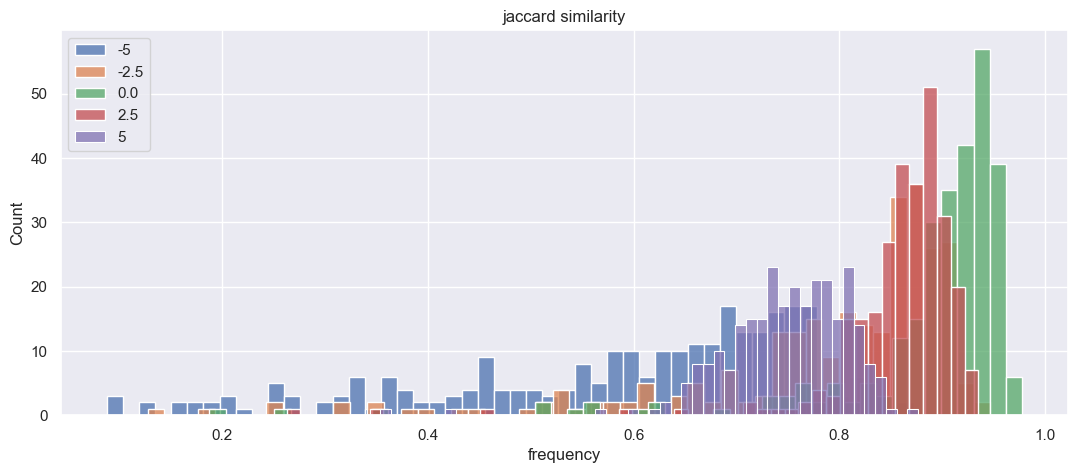

In [ ]:
plot_data = load_df_dict()

fig, ax = plt.subplots(figsize=(13,5))
for a in [-5, -2.5, 0.0, 2.5, 5]:
    a = str(a)
    sns.histplot(plot_data['jaccard_similarity_distribution_training'][a], label=a, bins=50, ax=ax, kde=False)
plt.legend();
plt.title('jaccard similarity')
plt.xlabel('frequency');

Below we see instead the average jaccard similarity, calculated on the training set, as a function of the threshold value, and print the best average and the best value associated with it.

max jaccard similarity: 0.8924353871008625
best threshold: 0.6


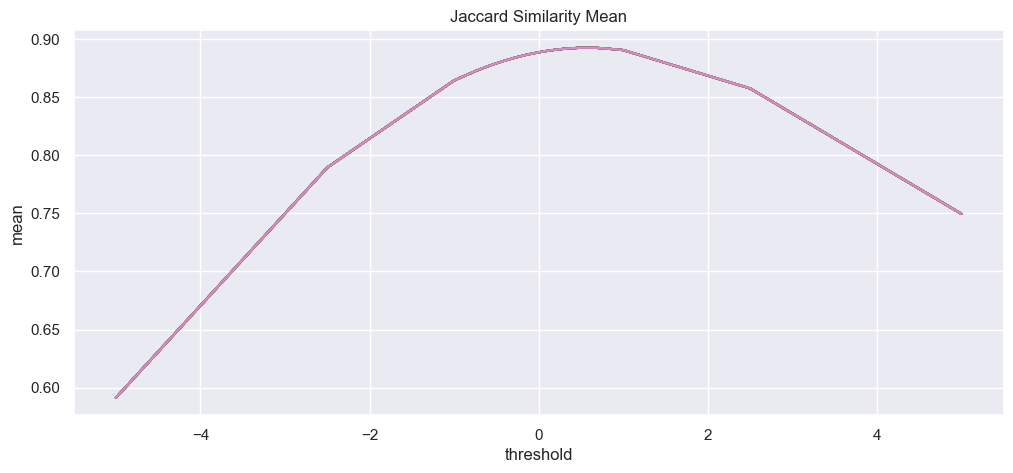

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
data = plot_data['jaccard_similarity_distribution_training'].describe().loc['mean'][1:]
x = data.index.astype(float)
y = data.values
for a in plot_data['jaccard_similarity_distribution_training'].columns[1:]:
    a = str(a)
    sns.lineplot(x=x, y=y, ax=ax)
plt.title('Jaccard Similarity Mean')
plt.xlabel('threshold');
plt.ylabel('mean');
print('max jaccard similarity:', max(y))
print('best threshold:', x[np.where(y == max(y))][0])

Now we define what are the values for which a pixel is associated with each of the 3 classes predicted by the model:
- x < -0.6: Not Horse
- 0.6 < x < 0.6: Rejection class
- x > 0.6: Horse

In [ ]:
threshold = 0.6

dummy = {'id':[]}
for j, (input, labels) in enumerate(test_loader):
    dummy['id'].append(test_data_indexes[j])

    output = model(input)
    val = float(jaccard(output>threshold, labels))

    if threshold in dummy:
        dummy[threshold].append(val)
    else:
        dummy[threshold] = [val]

plot_data['jaccard_similarity_distribution_test'] = pd.DataFrame(dummy).astype("float")
save_df_dict(plot_data)

Finally we show the jaccard similarity distribution calculated on the test set and the mean achieved.

jaccard similarity over test set
mean: 0.8814629697799683
std: 0.07172451338464955


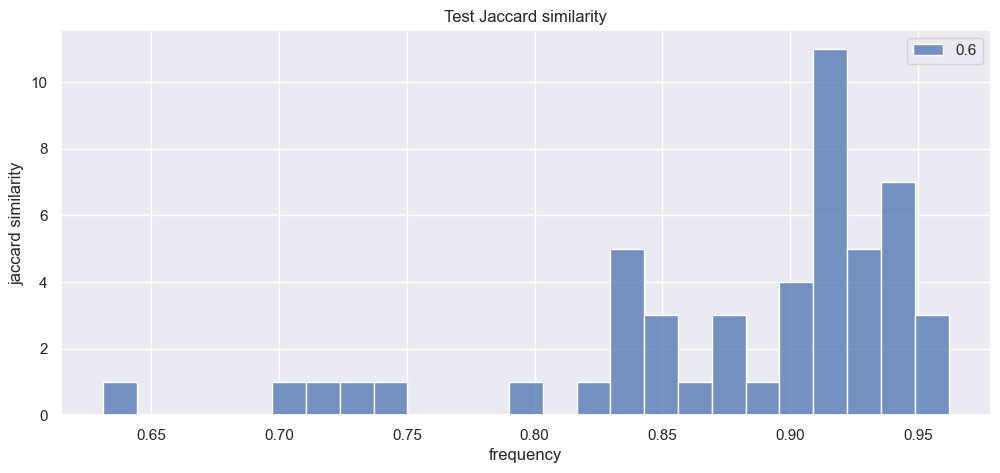

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
sns.histplot(plot_data['jaccard_similarity_distribution_test']['0.6'], label='0.6', bins=25, ax=ax, kde=False)
plt.legend();
plt.title('Test Jaccard similarity')
plt.xlabel('frequency');
plt.ylabel('jaccard similarity');
print('jaccard similarity over test set')
print('mean:', np.mean(plot_data['jaccard_similarity_distribution_test']['0.6']))
print('std:', np.std(plot_data['jaccard_similarity_distribution_test']['0.6']))

Let us now compare our result with the baseline represented by a segmentation approach that involves first a division into superpixels via SLICO and then a segmentation via NCut, remembering that the baseline cannot independently recognize which of the identified segments represent a horse and which do not, otherwise the CNN can perform the segmentation and also associate semantic values. We can see a great improvement in the mean and minimum.

In [ ]:
plot_data['evaluation'].set_index('index')

baseline (slico + NCut)  MiniSegNetDS
index                                       
mean                  0.639661      0.881463
std                   0.266745      0.072453
min                   0.000000      0.631190
25%                   0.546714      0.848364
50%                   0.724534      0.909318
75%                   0.832808      0.930581
max                   0.963874      0.961906

To finish the study, below we show the 3 worst segmentations, according to Jaccard Similarity, and for each sample we show in green the 'Horse' class and in gray the rejection class. Below each segmentation display is a visualization of the model output without subsequent editing or thresholding.

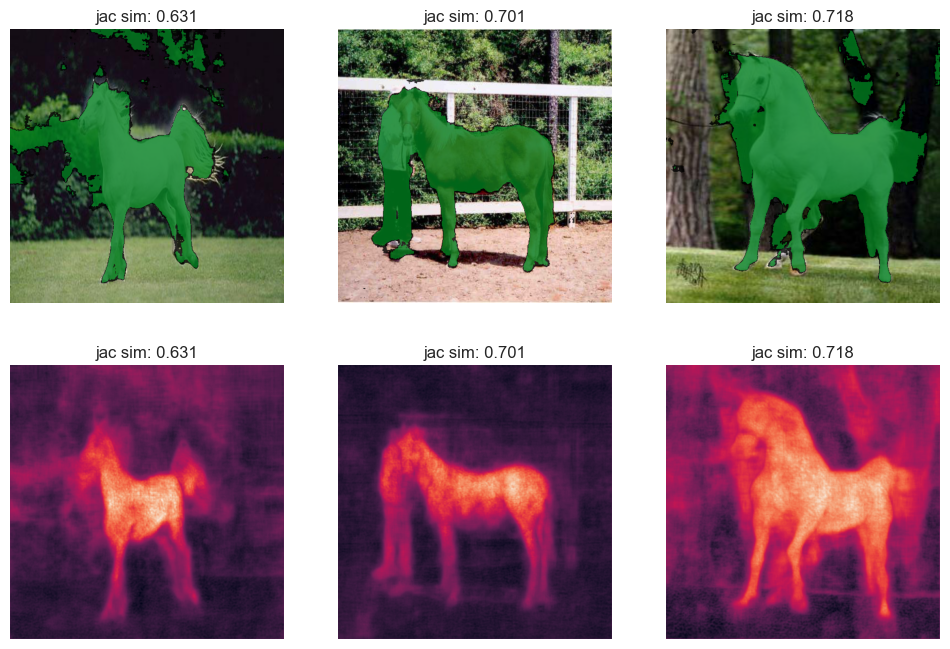

In [ ]:
true_id = list(plot_data['jaccard_similarity_distribution_test'].sort_values('0.6')['id'].values[:3].astype(int))
lab = list(plot_data['jaccard_similarity_distribution_test'].sort_values('0.6')['0.6'].values[:3])
ids = [test_data_indexes.index(id) for id in true_id]
test_images = [transforms.Resize((512,512))(torchvision.io.read_image(str(DATASET_DIR / f'horse/horse{test_data_indexes[id]:03d}.png')))
               for id in ids]
test_images_float = [test_set.__getitem__(id) for id in ids]

out_test = [model(torch.stack([im[0]]))[0][0] for im in test_images_float]

mask_1 = [torch.logical_and(im>-threshold, im<threshold) for im in out_test]
mask_2 =  [im>threshold for im in out_test]

img = [torchvision.utils.draw_segmentation_masks(test_images[i], torch.stack([mask_1[i], mask_2[i]]))
       for i in range(len(out_test))] + [torch.stack([im.cpu()]) for im in out_test]
plot_images(img, [f'jac sim: {jac:.3f}' for jac in lab]*2, 2, 3, permute=True, figsize=(12,8))

As above, we show the 3 best segmented images below.

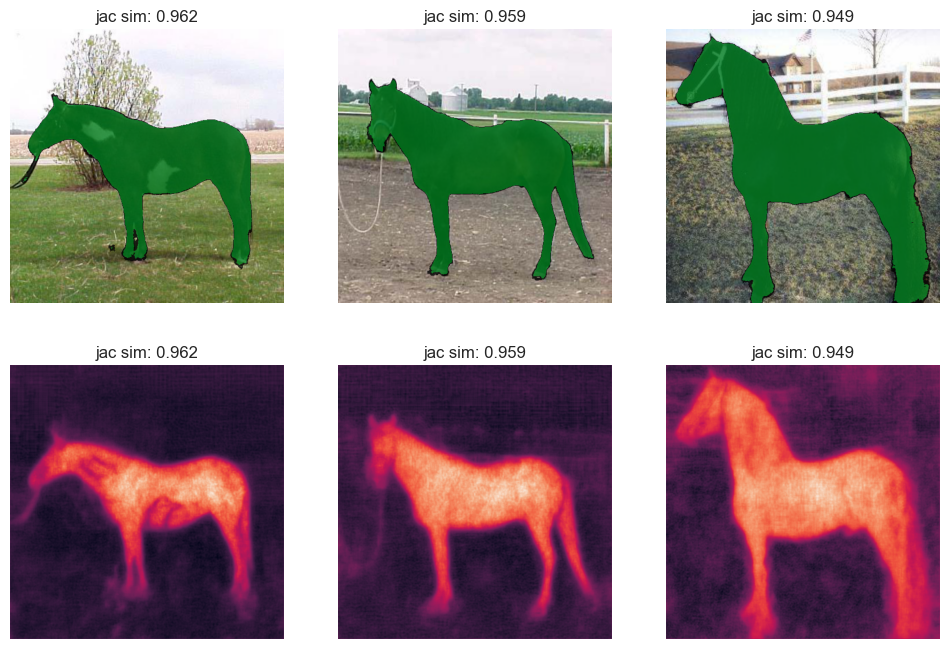

In [ ]:
true_id = list(plot_data['jaccard_similarity_distribution_test'].sort_values('0.6', ascending=False)['id'].values[:3].astype(int))
lab = list(plot_data['jaccard_similarity_distribution_test'].sort_values('0.6', ascending=False)['0.6'].values[:3])
ids = [test_data_indexes.index(id) for id in true_id]
test_images = [transforms.Resize((512,512))(torchvision.io.read_image(str(DATASET_DIR / f'horse/horse{test_data_indexes[id]:03d}.png')))
               for id in ids]
test_images_float = [test_set.__getitem__(id) for id in ids]

out_test = [model(torch.stack([im[0]]))[0][0] for im in test_images_float]

mask_1 = [torch.logical_and(im>-threshold, im<threshold) for im in out_test]
mask_2 =  [im>threshold for im in out_test]

img = [torchvision.utils.draw_segmentation_masks(test_images[i], torch.stack([mask_1[i], mask_2[i]]))
       for i in range(len(out_test))] + [torch.stack([im.cpu()]) for im in out_test]
plot_images(img, [f'jac sim: {jac:.3f}' for jac in lab]*2, 2, 3, permute=True, figsize=(12,8))

The objective of this study was to create a convolutional neural network to perform semantic segmentation on the ‘weizmann horse’ dataset. Initially, the problem was studied and the architectures were created and subsequently tested in the Model Selection phase. Finally, a Model Evaluation phase discussed the results and compared them with the baseline, noticing excellent improvements.

## Bibliography

1. He, K., Zhang, X., Ren, S., & Sun, J. (2016). "Deep Residual Learning for Image Recognition". In Proceedings of the IEEE conference on computer vision and pattern recognition (CVPR), 770-778. https://arxiv.org/abs/1512.03385.
2. Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications". arXiv preprint arXiv:1704.04861. https://arxiv.org/abs/1704.04861
3. Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). "SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation". IEEE Transactions on Pattern Analysis and Machine Intelligence, 39(12), 2481-2495. DOI: 10.1109/TPAMI.2016.2644615. https://ieeexplore.ieee.org/abstract/document/7803544
4. Ding, X., Zhang, X., Zhou, Y., Han, J., & Ding, G. (2022). "Scaling Up Your Kernels to 31x31: Revisiting Large Kernel Design in CNNs". arXiv preprint arXiv:2203.06717. https://ar5iv.labs.arxiv.org/html/2203.06717v1.
5. F. Yu and V. Koltun, "Multi-Scale Context Aggregation by Dilated Convolutions," in *Proceedings of the 4th International Conference on Learning Representations (ICLR)*, San Juan, Puerto Rico, 2016. Available: https://arxiv.org/abs/1511.07122
6. Weights & Biases. https://wandb.ai/site